In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
import seaborn as sns

from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [5]:
predictors = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO',
    'LABOR_PRODUCTIVITY',
    'SOCLIAB_SAL']

print(len(predictors))

29


In [6]:
DISTRESS_CRITERIA_1Y_OFF = [
 'DPHZ_vat_registration_cancelled_1y_off',
 'RUZ_indirect_criterion_1y_off',
 'RU_konkurz_1y_off',
 'RU_ostatne_konania_1y_off',
 'RUZ_cancelled_1y_off']


DISTRESS_CRITERIA_2Y_OFF = [
 'DPHZ_vat_registration_cancelled_2y_off',
 'RUZ_indirect_criterion_2y_off',
 'RU_konkurz_2y_off',
 'RU_ostatne_konania_2y_off',
 'RUZ_cancelled_2y_off']

In [5]:
financial_ratios_table_raw = pd.read_csv('../../DATA/FINAL/training_data.csv')
display(financial_ratios_table_raw.shape[0])

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1679947

In [6]:
def combined_issue_2y_off(row):
    if row.DPHZ_vat_registration_cancelled_2y_off == 1: return 1
    if row.RUZ_cancelled_2y_off == 1: return 1
    if row.RU_konkurz_2y_off == 1: return 1
    if row.RU_ostatne_konania_2y_off == 1: return 1
    return 0


def combined_issue_1y_off(row):
    if row.DPHZ_vat_registration_cancelled_1y_off == 1: return 1
    if row.RUZ_cancelled_1y_off == 1: return 1
    if row.RU_konkurz_1y_off == 1: return 1
    if row.RU_ostatne_konania_1y_off == 1: return 1
    return 0


financial_ratios_table_raw['direct_criterion_2y_off'] = financial_ratios_table_raw.apply(combined_issue_2y_off, axis = 1)
financial_ratios_table_raw['direct_criterion_1y_off'] = financial_ratios_table_raw.apply(combined_issue_1y_off, axis = 1)

In [7]:
financial_ratios_table_raw['year'].value_counts()

2021    242626
2020    237437
2019    227047
2018    215784
2017    202819
2016    192148
2015    184005
2014    178081
Name: year, dtype: int64

In [10]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0)
    return wide_df

In [9]:
previous_year_data = financial_ratios_table_raw[['entity_ico', 'year'] + predictors]
previous_year_data.columns = ['entity_ico', 'year'] + [col + '_previous' for col in predictors]
previous_year_data['year'] += 1

financial_ratios_table_raw = financial_ratios_table_raw.merge(previous_year_data, on = ['year', 'entity_ico'], how = 'left')


C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_12340\247793335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_year_data['year'] += 1


In [14]:
display(financial_ratios_table_raw.shape[0])
display(financial_ratios_table_raw.query('SAL_TA_previous == SAL_TA_previous').shape[0])

1679947

1336341

In [15]:
records = []


for i, row in financial_ratios_table_raw.iterrows():
    record = [row['financial_statement_id'], row['year']]
    for col in predictors:
        if row[col + '_previous'] == 0:
            value = np.NaN
        else:  
            value = row[col] / row[col + '_previous'] - 1
        record.append(value)
    records.append(record)

yty_growth = pd.DataFrame(records, columns=['financial_statement_id', 'year'] + [col + '_yty' for col in predictors])

yty_growth

,financial_statement_id,year,L3_yty,L2_yty,L1_yty,CF_CL_yty,CASH_TA_yty,SAL_TA_yty,TL_SAL_yty,INV_COST_yty,INV_SAL_yty,CC_SAL_yty,TA_SAL_yty,TL_TA_yty,CF_TL_yty,CL_TA_yty,NCL_TA_yty,EQ_TL_yty,EQ_TA_yty,CL_CC_yty,ROE_yty,EAT_TA_yty,ROA_BRUTTO_yty,CF_TA_yty,CF_SAL_yty,ROS_yty,EAT_YIE_yty,ROI_yty,ROA_NETTO_yty,LABOR_PRODUCTIVITY_yty,SOCLIAB_SAL_yty
0,2575566,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2976863,2015,-0.193176,-0.193176,0.019149,-0.518574,0.263114,-0.427829,1.165719,NaN,NaN,0.747533,0.747731,0.239161,-0.518489,0.239380,0.000078,-0.262308,-0.085881,0.239520,-0.34898,-0.404890,-0.405244,-0.403330,0.042818,0.040091,-0.354474,-0.404890,-0.404890,-1.000000,0.747867
2,3375702,2016,-0.997171,-0.997171,-0.448083,14.751965,191.231962,189.608247,0.825949,NaN,NaN,-0.995194,-0.994754,347.040947,14.763642,347.298942,-1.000000,-1.482510,-168.933350,379.177890,NaN,5477.856195,5485.392883,5485.392883,27.783607,27.744067,44.869935,5477.856195,5477.856195,NaN,0.821923
3,3757740,2017,-0.029911,-0.029911,-0.105376,-0.994137,-0.078774,0.010690,0.018844,NaN,NaN,-0.005804,-0.010577,0.029736,-0.994137,0.029736,NaN,0.000256,0.029999,0.024792,NaN,-0.993869,-0.993963,-0.993963,-0.994026,-0.993934,-0.992202,-0.996189,-0.993869,NaN,0.000525
4,3787505,2018,-0.986722,-0.986722,-0.796785,0.373861,13.465915,0.287379,54.294833,NaN,NaN,-0.995427,-0.223228,70.185420,0.373861,70.185420,NaN,0.008475,70.788702,12091.876156,NaN,95.299409,96.798864,96.798864,74.967409,73.802675,11.114468,153.901382,95.299409,NaN,0.291640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679942,5156278,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679943,4679250,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679944,2225050,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679945,2678436,2015,0.075488,0.075488,0.352690,9.317878,0.263476,0.602031,-0.236223,NaN,NaN,-0.731305,-0.375793,0.223595,6.876281,-0.065953,0.244195,2.315566,3.056911,1.169888,NaN,4.552539,8.637380,8.637380,5.015725,2.465937,2.445053,4.554942,4.552539,-0.220635,-1.000000


In [17]:
# financial_ratios_table_raw = financial_ratios_table_raw.merge(yty_growth, on = ['year', 'financial_statement_id'], how = 'left')
financial_ratios_table_raw.to_csv('../../DATA/FINAL/training_data_2y.csv', index = False)

In [2]:
financial_ratios_table_raw = pd.read_csv('../../DATA/FINAL/training_data_2y.csv')

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
predictors_previous = [col + '_previous' for col in predictors]
predictors_yty = [col + '_yty' for col in predictors]

In [8]:
issues_columns_list = ['DPHZ_vat_registration_cancelled',
 'DPHZ_vat_registration_cancelled_1y_off',
 'DPHZ_vat_registration_cancelled_2y_off',
 'RUZ_cancelled',
 'RUZ_cancelled_1y_off',
 'RUZ_cancelled_2y_off',
 'RUZ_indirect_criterion',
 'RUZ_indirect_criterion_1y_off',
 'RUZ_indirect_criterion_2y_off',
 'RU_konkurz',
 'RU_konkurz_1y_off',
 'RU_konkurz_2y_off',
 'RU_ostatne_konania',
 'RU_ostatne_konania_1y_off',
 'RU_ostatne_konania_2y_off',
 'direct_criterion_1y_off',
 'direct_criterion_2y_off']

issues_2y_off_list = [
 'DPHZ_vat_registration_cancelled_2y_off',
 'RUZ_cancelled_2y_off',
 'RUZ_indirect_criterion_2y_off',
 'RU_konkurz_2y_off',
 'RU_ostatne_konania_2y_off',
 'direct_criterion_2y_off'
]



In [11]:
display(get_sample_sizes(financial_ratios_table_raw, 'year', 'sal_class'))

for issue in issues_2y_off_list:
    print(issue)
    display(get_sample_sizes(financial_ratios_table_raw, 'year', issue))

count                                     
sal_class 0. <50,000 1. Mikro 2. Malý 3. Stredný 4. Veľký
year                                                     
2014          103279    67034    5891       1547      330
2015          104160    71274    6540       1665      366
2016          108334    75313    6509       1615      377
2017          114406    79539    6754       1720      400
2018          121786    84603    7125       1858      412
2019          128647    88879    7197       1903      421
2020          139744    88667    6836       1799      391
2021          142060    90981    7298       1851      436

DPHZ_vat_registration_cancelled_2y_off


count      
DPHZ_vat_registration_cancelled_2y_off     0.0   1.0
year                                                
2014                                    177877   204
2015                                    183773   232
2016                                    191851   297
2017                                    202414   405
2018                                    214709  1075
2019                                    225836  1211
2020                                    236499   938
2021                                    241407  1219

RUZ_cancelled_2y_off


count      
RUZ_cancelled_2y_off       0     1
year                              
2014                  170402  7679
2015                  175038  8967
2016                  185802  6346
2017                  199553  3266
2018                  212878  2906
2019                  222862  4185
2020                  233585  3852
2021                  241163  1463

RUZ_indirect_criterion_2y_off


count       
RUZ_indirect_criterion_2y_off     0.0    1.0
year                                        
2014                           144056  34025
2015                           151275  32730
2016                           160550  31598
2017                           172296  30523
2018                           183687  32097
2019                           193462  33585
2020                           212617  24820
2021                           242626      0

RU_konkurz_2y_off


count     
RU_konkurz_2y_off     0.0  1.0
year                          
2014               177538  543
2015               183511  494
2016               191668  480
2017               202325  494
2018               215321  463
2019               226578  469
2020               236929  508
2021               242156  470

RU_ostatne_konania_2y_off


count     
RU_ostatne_konania_2y_off     0.0  1.0
year                                  
2014                       177946  135
2015                       183893  112
2016                       192089   59
2017                       202785   34
2018                       215744   40
2019                       227000   47
2020                       237390   47
2021                       242589   37

direct_criterion_2y_off


count      
direct_criterion_2y_off       0     1
year                                 
2014                     169655  8426
2015                     174321  9684
2016                     185064  7084
2017                     198714  4105
2018                     211393  4391
2019                     221238  5809
2020                     232171  5266
2021                     239493  3133

In [12]:
display(get_sample_sizes(financial_ratios_table_raw.query('year == 2017 '), 'is_outlier', 'sal_class'))
display(get_sample_sizes(financial_ratios_table_raw.query('year == 2017'), 'RUZ_indirect_criterion', 'direct_criterion_2y_off'))

count                                     
sal_class  0. <50,000 1. Mikro 2. Malý 3. Stredný 4. Veľký
is_outlier                                                
False          101415    77143    6628       1685      392
True             1140      867      75         19        5

count      
direct_criterion_2y_off       0     1
RUZ_indirect_criterion               
0.0                      173919  3226
1.0                       24795   879

In [13]:
YEARS = sorted(financial_ratios_table_raw['year'].unique())
YEARS

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [14]:
for col in issues_columns_list:
    financial_ratios_table_raw[col] = financial_ratios_table_raw[col].fillna(0)

In [15]:
master_set_2017 = set(financial_ratios_table_raw['entity_ico'].unique())

for year in 2015, 2016, 2017:
    subset = financial_ratios_table_raw.query('year == @year')
    subset_set = set(subset['entity_ico'].unique())

    master_set_2017 = master_set_2017.intersection(subset_set)


display(len(master_set_2017))


master_set_2018 = set(financial_ratios_table_raw['entity_ico'].unique())

for year in 2016, 2017, 2018:
    subset = financial_ratios_table_raw.query('year == @year')
    subset_set = set(subset['entity_ico'].unique())

    master_set_2018 = master_set_2018.intersection(subset_set)



display(len(master_set_2018))

161697

173544

In [16]:
data_2017 = financial_ratios_table_raw.query('entity_ico in @master_set_2017 and year == 2017')
data_2018 = financial_ratios_table_raw.query('entity_ico in @master_set_2018 and year == 2018')
financial_ratios_table_raw = None

In [17]:
SAL_CLASSES = ['1. Mikro', '2. Malý', '3. Stredný', '4. Veľký']
SKNACE_GROUPS = ['G', 'C', 'F', 'H', 'M', 'N', 'L']
REPORT_TEMPLATES = [687, 699]

# G - VEĽKOOBCHOD A MALOOBCHOD OPRAVA MOTOROVÝCH VOZIDIEL A MOTOCYKLOV
# C - Priemyselná výroba
# F - STAVEBNÍCTVO
# H - DOPRAVA A SKLADOVANIE
# M - ODBORNÉ VEDECKÉ A TECHNICKÉ ČINNOSTI
# N - ADMINISTRATÍVNE A PODPORNÉ SLUŽBY
# L - ČINNOSTI V OBLASTI NEHNUTEĽNOSTÍ

In [18]:
data_2018['sal_class'].value_counts()

0. <50,000    88497
1. Mikro      75950
2. Malý        6872
3. Stredný     1822
4. Veľký        403
Name: sal_class, dtype: int64

In [19]:
def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data

financial_ratios_table_2017 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        for template_id in REPORT_TEMPLATES:
            subset = data_2017.query('sal_class == @sal_class and sknace_division == @sknace and financial_report_template_id == @template_id')
            if subset.shape[0] < 3:
                continue
            for col in predictors + predictors_previous + predictors_yty:
                col_mean = subset[col].mean()
                subset[col].fillna(col_mean)

            financial_ratios_table_2017 = pd.concat([financial_ratios_table_2017, subset], axis = 0)

display(financial_ratios_table_2017.shape[0])


financial_ratios_table_2018 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        for template_id in REPORT_TEMPLATES:
            # print(f'sales_class: {sal_class}; sknace: {sknace}')
            subset = data_2018.query('sal_class == @sal_class and sknace_division == @sknace and financial_report_template_id == @template_id')
            if subset.shape[0] < 3:
                continue
            for col in predictors + predictors_previous + predictors_yty:
                col_mean = subset[col].mean()
                subset[col].fillna(col_mean)

            financial_ratios_table_2018 = pd.concat([financial_ratios_table_2018, subset], axis = 0)

display(financial_ratios_table_2018.shape[0])

62518

66647

In [20]:
group_column = 'sal_class'
sample = financial_ratios_table_2018.copy().query('financial_report_template_id == 699')

display(
    pd.concat(
        [
            
            sample
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size')
        ] + [
   
            sample.query(f'{issue_name} == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame(issue_name) for issue_name in issues_2y_off_list
        ], axis = 1
        ).reset_index())

,sal_class,sample_size,DPHZ_vat_registration_cancelled_2y_off,RUZ_cancelled_2y_off,RUZ_indirect_criterion_2y_off,RU_konkurz_2y_off,RU_ostatne_konania_2y_off,direct_criterion_2y_off
0,1. Mikro,25673,225,224.0,3292,102,11.0,542
1,2. Malý,5583,46,58.0,337,43,16.0,153
2,3. Stredný,1555,4,18.0,62,14,4.0,37
3,4. Veľký,356,1,NaN,8,5,NaN,5


In [21]:
financial_ratios_table_2017 = financial_ratios_table_2017.query('financial_report_template_id == 699 and sal_class in ["2. Malý", "3. Stredný"]')
financial_ratios_table_2018 = financial_ratios_table_2018.query('financial_report_template_id == 699 and sal_class in ["2. Malý", "3. Stredný"]')

In [22]:
predictors_extended = predictors + predictors_previous + predictors_yty
predictors_2y_abs = predictors + predictors_previous
predictors_2y_rel = predictors + predictors_yty

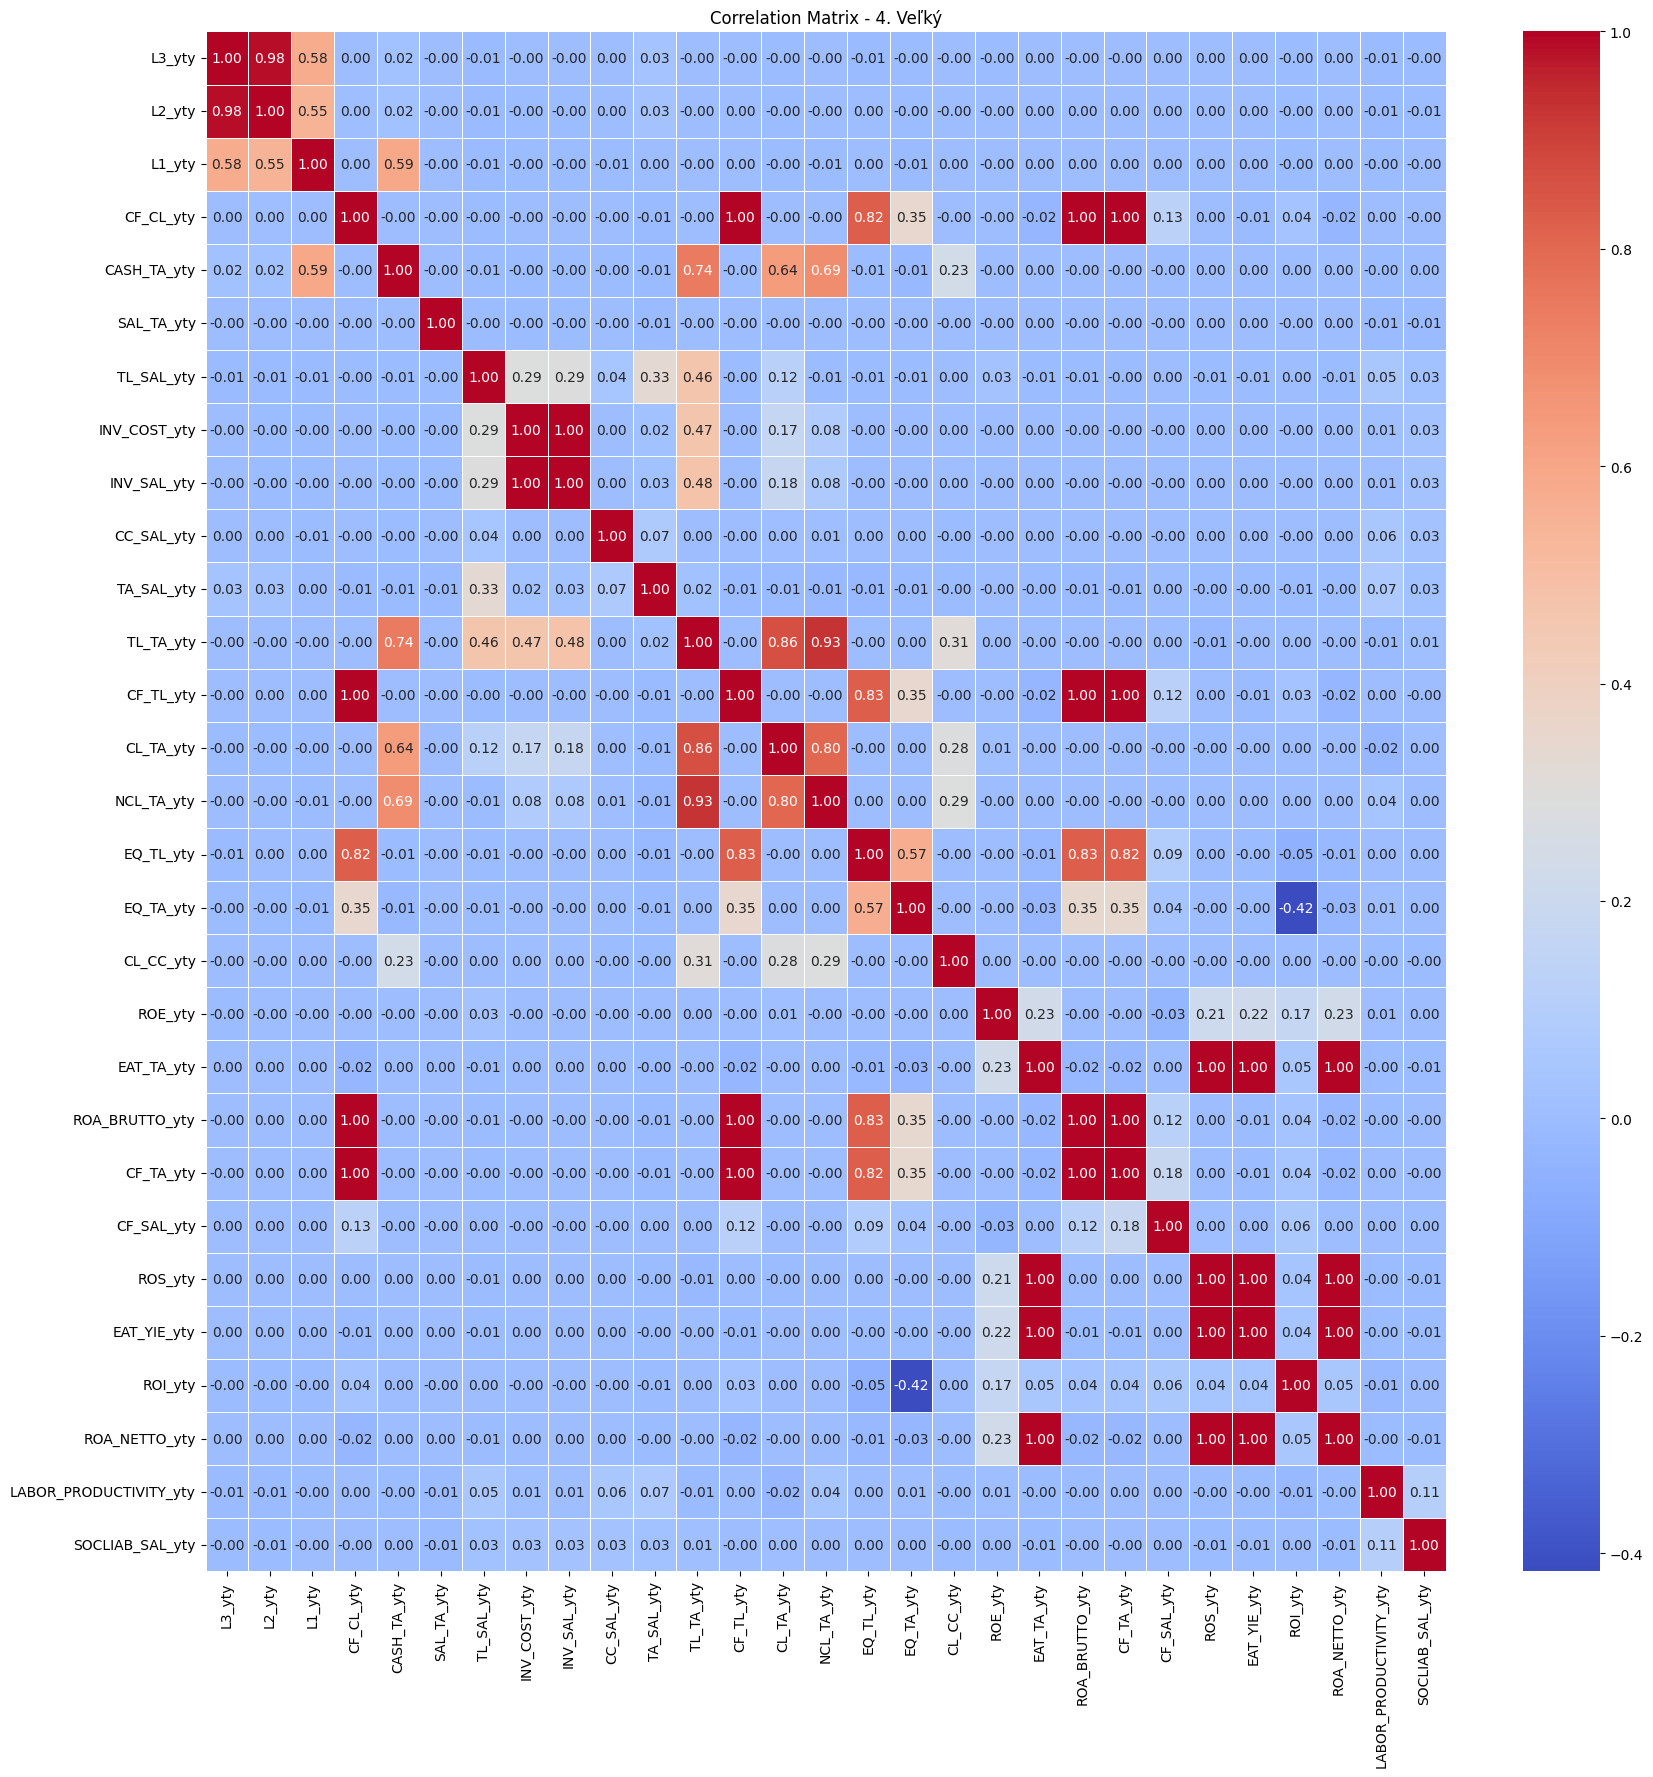

In [23]:
# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[predictors_yty].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix - {sal_class}')
plt.show()

In [86]:
# import pandas as pd
# import statsmodels.api as sm

# def calculate_vif(data):
#     # Add a constant term to the independent variables matrix
#     X = sm.add_constant(data)

#     # Compute VIF for each feature
#     vif_data = pd.DataFrame()
#     vif_data['Feature'] = X.columns
#     vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]
#     vif_data['VIF'] = vif_data['VIF'].apply(lambda x: round(x, 2))

#     return vif_data



# vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(sample[predictors_2y_rel]), columns=predictors_2y_rel)).sort_values(by = 'VIF')
# display(vif_result)


## Models

### Logistic Regression

In [62]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


def generate_train_test_sample(data, features_selection, criterion):
    train_sample = pd.concat([data.query(f'{criterion} == 0').sample(500, replace = True), data.query(f'{criterion} == 1').sample(500, replace = True)], axis=0)

    X =  fill_missing_values_mean(train_sample[features_selection].values)
    y =  train_sample[criterion].fillna(1).values
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # return X_train, X_test, y_train, y_test

    return X, X, y, y 


def generate_logit_model(data, features_selection, criterion):

    X_train, X_test, y_train, y_test = generate_train_test_sample(data, features_selection, criterion)
    
    # Creating SMOTE and RandomUnderSampler objects
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    
    logistic_model = LogisticRegression(max_iter=2000)

    # Creating a pipeline to combine sampling and modeling
    pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Logistic Regression', logistic_model)])
        
    # Fitting the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Define scoring metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy']

    # Perform cross-validation
    cv_results = cross_validate(pipeline, X_test, y_test, cv=5, scoring=scoring)

    
    return (
        np.mean(cv_results['test_accuracy']),
        np.mean(cv_results['test_precision']),
        np.mean(cv_results['test_recall']),
        np.mean(cv_results['test_f1']),
        np.mean(cv_results['test_roc_auc']),
        np.mean(cv_results['test_balanced_accuracy']))

In [77]:


possible_features = predictors_2y_rel[::]
selected_features = ['TL_TA', 'ROA_BRUTTO', 'ROS', 'L3_yty', 'INV_COST_yty', 'L2', 'CF_TA']

for feature in selected_features:
    possible_features.remove(feature)

summary = []

for candidate_feature in possible_features:

    summary_row = []
    summary_row.append(selected_features)
    summary_row.append(candidate_feature)

    summary_row += generate_logit_model(financial_ratios_table_2017, [candidate_feature] + selected_features, 'RUZ_indirect_criterion_2y_off')
    summary.append(summary_row)


c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [79]:
logit_summary_df = pd.DataFrame(summary, columns = ['selected_features', 'candidate_feature', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score', 'Balanced Accuracy'])

display(logit_summary_df.shape[0])
display(logit_summary_df.sort_values('Accuracy', ascending = False).head(20))
# display(logit_summary_df.sort_values('F1 Score', ascending = True).head(20))


51

,selected_features,candidate_feature,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Balanced Accuracy
49,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",LABOR_PRODUCTIVITY_yty,0.828,0.820959,0.842,0.830105,0.89872,0.828
17,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",EAT_TA,0.827,0.811200,0.852,0.831070,0.88774,0.827
39,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",CL_CC_yty,0.820,0.830661,0.804,0.816658,0.88412,0.820
4,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",SAL_TA,0.817,0.800186,0.846,0.822267,0.88364,0.817
10,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",CF_TL,0.817,0.796592,0.852,0.823012,0.89204,0.817
48,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",ROA_NETTO_yty,0.816,0.796294,0.850,0.821719,0.88104,0.816
31,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",CC_SAL_yty,0.815,0.806316,0.830,0.817584,0.87730,0.815
23,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",SOCLIAB_SAL,0.815,0.826264,0.800,0.811923,0.87806,0.815
36,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",NCL_TA_yty,0.813,0.840027,0.774,0.804688,0.88534,0.813
43,"[TL_TA, ROA_BRUTTO, ROS, L3_yty, INV_COST_yty,...",CF_TA_yty,0.812,0.799955,0.836,0.816955,0.89142,0.812


Cross-Validation Results:
Accuracy: 0.84 +/- 0.04
Precision: 0.10 +/- 0.03
Recall: 0.23 +/- 0.09
F1 Score: 0.13 +/- 0.03
ROC AUC Score: 0.57 +/- 0.03
Balanced Accuracy: 0.55 +/- 0.03


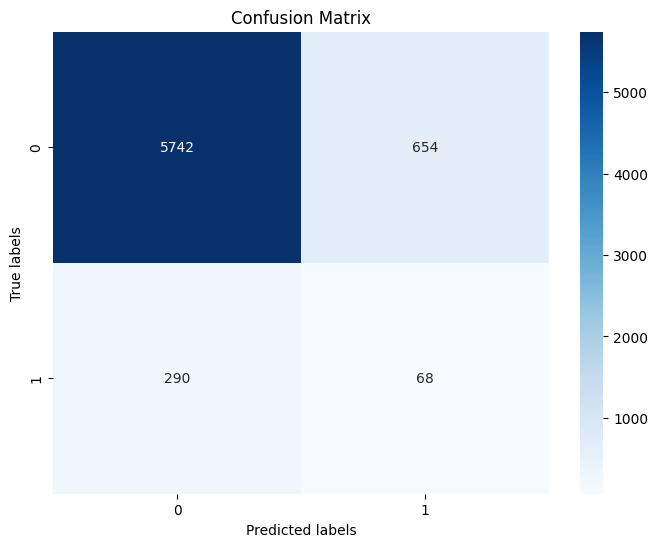

In [101]:
generate_logit_model(financial_ratios_table_2017, ['SAL_TA'], 'RUZ_indirect_criterion_2y_off')